# Amortized Inference for a NLME Model

In [1]:
# load necessary packages
import numpy as np
import pandas as pd
import itertools

# for plots
import matplotlib.pyplot as plt
from IPython.display import display
from heatmap import corrplot

# optimization
from pypesto import visualize, optimize, profile, engine

from inference.inference_functions import run_population_optimization, create_boundaries_from_prior
from inference.nlme_objective import ObjectiveFunctionNLME
from inference.helper_functions import transform_pesto_results
from inference.ploting_routines import plot_real_vs_synthetic, plot_real_and_estimated, \
    plot_parameter_estimates, plot_estimated_distributions, visualize_pesto_result

/Users/jonas.arruda/miniconda/envs/AmortizedNLMEs/lib/python3.9/site-packages/bayesflow/trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# specify which model to use
model_name = ['fröhlich-small', 'fröhlich-large', 'fröhlich-sde', 'pharmacokinetic_model', 
              'clairon_model', 'clairon_small_model'][-1]

## Load model

In [3]:
if model_name == 'fröhlich-small':
    from models.froehlich_model_small import FroehlichModelSmall
    model = FroehlichModelSmall(load_best=True)
    
    use_presimulation = False
elif model_name == 'fröhlich-large':
    from models.froehlich_model_large import FroehlichModelLarge
    model = FroehlichModelLarge(load_best=True)
    
    use_presimulation = True
    presimulation_path = 'data/presimulations_froehlich_large'

elif model_name == 'fröhlich-sde':
    from models.froehlich_model_sde import FroehlichModelSDE
    model = FroehlichModelSDE(load_best=True)

    use_presimulation = True
    presimulation_path = 'data/presimulations_froehlich_sde'
    
elif model_name == 'pharmacokinetic_model':
    from models.pharmacokinetic_model import PharmacokineticModel
    model = PharmacokineticModel(load_best=True)
    
    use_presimulation = True
    presimulation_path = 'data/presimulations_pharma'
elif model_name == 'clairon_model':
    from models.clairon_model import ClaironModel
    model = ClaironModel(load_best=True)

    use_presimulation = True
    presimulation_path = 'data/presimulations_clairon'
elif model_name == 'clairon_small_model':
    from models.clairon_small_model import ClaironSmallModel
    model = ClaironSmallModel(load_best=True)

    use_presimulation = True
    presimulation_path = 'data/presimulations_small_clairon'
else:
    raise NotImplementedError('model not implemented')

path_store_network = 'networks/' + model.network_name

# assemble simulator and prior
simulator = model.build_simulator()
trainer = model.build_trainer(path_store_network)

  Activating project at `~/PyCharm Projects/AmortizedNLME/models/SimulatorSmallClairon`


using LSTM with 8 units as summary network
using a 7-layer cINN as inference network
Using uniform prior
[[-10   5]
 [ -5  10]
 [ -5  10]
 [-20   0]
 [-10   0]
 [-10   0]
 [-10   0]]
Using the small ClaironModel


INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 7)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 7, 3)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Loaded loss history from networks/amortizer-small-clairon-uniform-7layers-2coupling-LSTM-500epochs/history_294.pkl.
INFO:root:Loaded simulation memory from networks/amortizer-small-clairon-uniform-7layers-2coupling-LSTM-500epochs/memory.pkl
INFO:root:Networks loaded from networks/amortizer-small-clairon-uniform-7layers-2coupling-LSTM-500epochs/ckpt-294
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Model: "amortized_posterior"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Inverti  multiple                 519974    
 bleNetwork)                                                     
                                                                 
 lstm (LSTM)                 multiple                  384       
                                                                 
Total params: 520,358
Trainable params: 520,260
Non-trainable params: 98
_________________________________________________________________
None


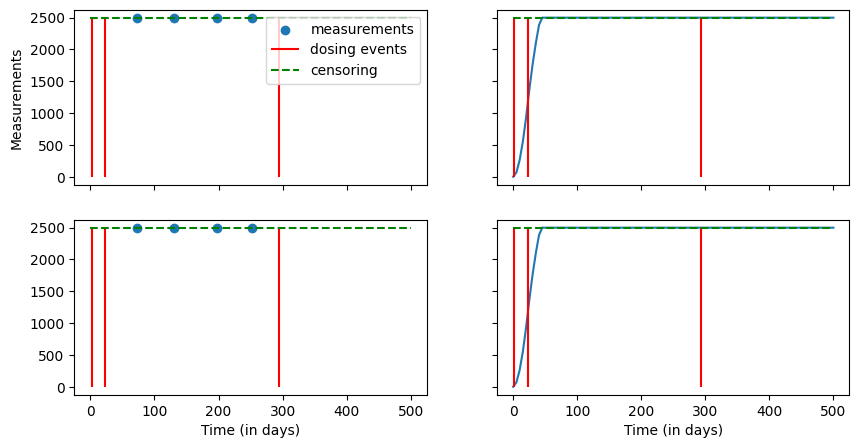

In [4]:
model.print_and_plot_example()

## Estimating Population Parameters

Now we want to use the amortizer to generate samples such that we can minimize the negative log-likelihood of the data given the population parameters of the mixed effect model:
$$
    \beta^*,\Psi^* \approx 
    \underset{\beta,\Psi}{\arg\min} -\sum_i \log\left( \frac1M \sum_j^M \frac{p(\phi_j \mid \beta,\Psi)}{p(\phi_j)} \right).
$$

Remark: the objective value is not the likelihood value since the sum over $\log p(y_i)$ is missing.
One part of the objective function increases logarithmically with the sample size $M$.
On the other hand, the approximation gets better (therby decreasing the value?!)

$\beta$ is called ```theta_population``` in the code.


$\log \phi$ cell specific parameters, sampled from $\mathcal{N}(\beta,\Psi)$
$$
    p( \phi \mid \beta,\Psi) = (2\pi)^{-k/2}\vert \Psi\vert^{-1/2} \prod_{l=1}^k \phi_l^{-1} \exp \left(-\frac12 (\log \phi-\beta)^T \Psi^{-1}  (\log \phi-\beta) \right)
$$

Assumptions to start with: $\Psi$ is a diagonal matrix, need better parameterization for other types

$$
    \beta^*,\Psi^* \approx
    \underset{\beta,\Psi}{\arg\min} -\sum_i \left(\log \frac1M \sum_j^M \frac{p( \phi_j \mid \beta,\Psi)}{p( \phi_j)} \right) \\
     =  \underset{\beta,\Psi}{\arg\min} -\sum_i \left(\log\left(\vert \Psi\vert^{-1/2} \right) -\log M -
    \log\left(\vert \Sigma\vert^{-1/2}\right) +\log \sum_j^M \exp \left(-\frac12 (\log\phi_j-\beta)^T \Psi^{-1}  (\log\phi_j-\beta) + \frac12 (\log\phi_j-\mu)^T \Sigma^{-1}  (\log\phi_j-\mu) \right)\right)
$$

if the prior is $p( \phi) = (2\pi)^{-k/2}\vert \Sigma\vert^{-1/2} \prod_{l=1}^k \phi_l^{-1}\exp \left(-\frac12 (\log \phi-\mu)^T \Sigma^{-1}  (\log\phi-\mu) \right)$.


For purpose of optimization we also parametrize $\Psi$ by a log-transformation since diagonal entries must be positive.

# Define Objective Function

In [5]:
use_covariates = False
prior_std = model.prior_std
prior_mean = model.prior_mean
param_names = model.param_names
    
if 'clairon' in model_name and use_covariates:
    param_names += ['c_age', 'c_gender']

In [6]:
# for huber loss
# 1.5 times the median of the posterior standard deviations
#samples_sigma = np.median(model.draw_posterior_samples(data=obs_data, n_samples=1000)[:, :, -1])
#huber_loss = np.exp(samples_sigma)*1.5
huber_loss = None
print(huber_loss)

None


In [7]:
cov_type = ['diag', 'cholesky'][0]

if use_covariates and 'clairon' in model_name:
    #simulator_noise_free = model.build_simulator(with_noise=False)
    data, covariates = model.load_data(n_data=50, load_covariates=True)
    def covariate_mapping(param_samples, covariates, params, tres=0.001):
        additive_cov = np.sum(params[-2:]*covariates, axis=1)
        #multiplicative_cov = np.sum(np.exp(params[-2:])*covariates, axis=1)
        transformed_param_samples = np.exp(param_samples)
        for s_id in range(transformed_param_samples.shape[0]):
            transformed_param_samples[s_id, :, 0] -= additive_cov[s_id]  # cov on one parameter
            #transformed_param_samples[s_id, :, 0] /= multiplicative_cov[s_id]


            #_, t_measurements, dose_amount, doses_time_points = convert_to_observables(data[s_id])
            #median_param = np.median(param_samples[s_id], axis=0)
            #sim = batch_simulator(median_param[np.newaxis],
            #                            t_measurements=t_measurements,
            #                            dose_amount=dose_amount,
            #                            t_doses=doses_time_points)
            #y, _, _, _ = convert_to_observables(sim[0])
            #transformed_param_samples[s_id, :, -4] -= np.exp(params[-4]) + np.exp(params[-3])*np.median(y)

        transformed_param_samples[transformed_param_samples < 0] = tres

        # append parameters of covariances, which are (log) normal with mean beta
        param_samples_cov = np.concatenate((np.log(transformed_param_samples),
                                            np.ones((transformed_param_samples.shape[0],transformed_param_samples.shape[1], 2))*params[-2:]),
                                           axis=2)
        return param_samples_cov
    param_dim = len(param_names)
else:
    covariate_mapping = None
    covariates = None
    param_dim = None

obj_fun_amortized = ObjectiveFunctionNLME(model_name=model.name,
                                          param_samples=np.empty((1,1,1)),
                                          prior_mean=prior_mean,
                                          prior_std=prior_std,
                                          covariance_format=cov_type,
                                          covariates=covariates,
                                          covariate_mapping=covariate_mapping,
                                          # np.exp(-3.41) * 1.5
                                          penalize_correlations=None,
                                          huber_loss_delta=huber_loss,
                                          prior_type=model.prior_type,  # TODO: prio
                                          prior_bounds=model.prior_bounds  # for uniform prior
                                          )

In [8]:
pop_param_names = ['pop-' + name for name in param_names]
var_param_names = ['var-' + name for name in param_names]
full_param_names = pop_param_names + var_param_names

if cov_type == 'cholesky' and len(full_param_names) == len(param_names)*2:
    # add  correlation names to full parameter names
    # make all possible combinations of parameter names
    combinations = list(itertools.combinations(param_names, 2))
    # create upper triangular matrix of parameter names
    psi_inverse_upper = np.chararray((len(param_names), len(param_names)), itemsize=100, unicode=True)
    psi_inverse_upper[np.diag_indices(len(param_names))] = "1"
    psi_inverse_upper[np.triu_indices(len(param_names), k=1)] = [f"corr_{x}_{y}" for x, y in combinations]
    # extract lower triangular matrix of parameter names, so that they are ordered as in the covariance matrix
    corr_names = list(psi_inverse_upper.T[np.tril_indices(len(param_names), k=-1)])
    # add correlation names to full parameter names
    full_param_names = full_param_names + corr_names
    print(full_param_names)

# Load Data

In [72]:
# define how many data points are used for optimization
n_data = 1000
load_real_data = True
# load data
if 'fröhlich' in model_name:
    obs_data, true_pop_parameters = model.load_data(n_data=n_data, load_eGFP=load_real_data, load_d2eGFP=False)
    
    # load SDE data for comparison
    #from models.froehlich_model_sde import FroehlichModelSDE
    #model_sde = FroehlichModelSDE(load_best=True)
    #obs_data, true_pop_parameters_sde = model_sde.load_data(n_data=n_data, load_eGFP=load_real_data, load_d2eGFP=False)
    #true_pop_parameters = None
else:
    obs_data = model.load_data(n_data=n_data, synthetic=not load_real_data)
    true_pop_parameters = None
results_to_compare = None
print(len(obs_data), 'individuals')

742 individuals


In [73]:
if not load_real_data:
    if model_name == 'fröhlich-small':
        path = f'output/results_monolix/small_model/estimated_parameters_synthetic_{n_data}_cells.csv'
        results_monolix = pd.read_csv(path, index_col=0, header=0)
        results_to_compare = results_monolix[results_monolix.columns[0]].values[[0, 1, 2, 3, 4, 10, 5, 6, 7, 8, 9]]
        results_to_compare[5] = np.log(results_to_compare[5])  # sigma to log
        results_to_compare = np.concatenate((results_to_compare, [0]))[np.newaxis, :]
    elif model_name == 'fröhlich-large':
        path = f'output/results_monolix/large_model/synthetic_{n_data}_poppars.csv'
        results_monolix = pd.read_csv(path, index_col=0, header=0)
        results_to_compare = results_monolix[results_monolix.columns[0]].values[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 20,
                                                                                 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]]
        results_to_compare[10] = np.log(results_to_compare[10])  # sigma to log
        results_to_compare = np.concatenate((results_to_compare, [0]))[np.newaxis, :]
    elif model_name == 'fröhlich-sde':
        pass

if False: #model_name == 'pharmacokinetic_model':
    raw_nonmem_data = pd.read_csv(f'output/results_nonmem/retries_sunitinib_lognor.csv', delimiter=',',
                           index_col=0, header=0)
    # remove uninformative columns and add missing columns
    raw_nonmem_data = raw_nonmem_data[raw_nonmem_data.columns[[0,1,3,4,5,6,7,9,11,12]+[13,15,18,22]+[14,16,17,19,20,21]+[25,39,40]]]
    raw_nonmem_data.sort_values(by=['ofv'], inplace=True)

    # remove uninformative columns and add missing columns
    corr_names_nonmem = ['eta_1_eta_0', 'eta_2_eta_0', 'eta_2_eta_1', 'eta_3_eta_0', 'eta_3_eta_1', 'eta_3_eta_2']
    raw_nonmem_data.columns = full_param_names[:10] + full_param_names[25:29] + corr_names_nonmem + list(raw_nonmem_data.columns[-3:])
    # log transform population parameters
    raw_nonmem_data[full_param_names[:10]] = raw_nonmem_data[full_param_names[:10]].abs().apply(np.log)
    # add variances
    raw_nonmem_data[full_param_names[10:25]] = np.zeros(15)
    raw_nonmem_data[full_param_names[29]] = 0
    # get results to compare
    results_to_compare = raw_nonmem_data[full_param_names[:30]+corr_names_nonmem].values

if cov_type == 'cholesky':
    n_corr = len(param_names) * (len(param_names)-1) // 2
    if true_pop_parameters is not None:
        # add 0 correlations to true population parameters
        true_pop_parameters = np.concatenate((true_pop_parameters, np.zeros(n_corr)), axis=0)
    if results_to_compare is not None:
        # add 0 correlations to results to compare
        # not true for pharmacokinetic model
        if model_name != 'pharmacokinetic_model':
           results_to_compare = np.concatenate((results_to_compare, np.nan*np.ones((results_to_compare.shape[0], n_corr))), axis=1)

# Analyse correlations between parameters

In [74]:
param_samples = model.draw_posterior_samples(data=obs_data, n_samples=100)
param_median = np.median(param_samples, axis=1)
# correlations without sigma
median_df = pd.DataFrame(param_median[:, :-1], columns=model.param_names[:-1])
corr_df = median_df.corr()

Correlation Matrix from Median


<Axes: >

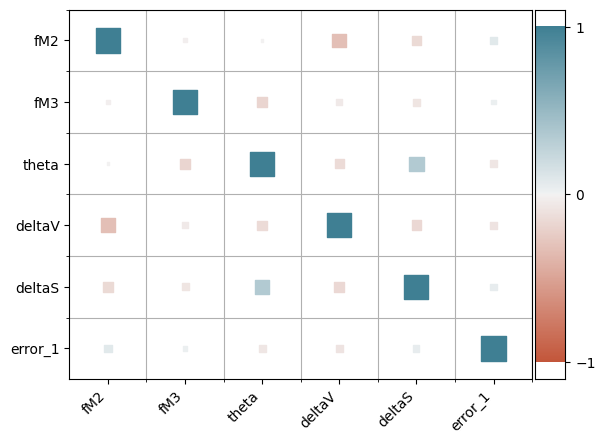

In [75]:
print('Correlation Matrix from Median')
corrplot(corr_df, size_scale=300)

In [76]:
if cov_type == 'cholesky':
    # Find pairs with correlation above the threshold
    threshold = 0
    abs_corr_matrix = corr_df.abs()
    high_corr_pairs = abs_corr_matrix[abs_corr_matrix > threshold].unstack()
    #high_corr_pairs = high_corr_pairs[high_corr_pairs['level_0'] != high_corr_pairs['level_1']]
    high_corr_pairs = high_corr_pairs[high_corr_pairs < 1].sort_values(ascending=False)

    # find indices corresponding to pairs with high correlations
    high_corr_pairs_index = []
    high_corr_pairs_names = []
    for x,y in high_corr_pairs.index:
        name = f'corr_{x}_{y}'
        high_corr_pairs_index += [p_i for p_i, p_name in enumerate(full_param_names) if name == p_name]
        high_corr_pairs_names += [p_name for p_i, p_name in enumerate(full_param_names) if name == p_name]
    print(high_corr_pairs_names, len(high_corr_pairs_index))

# Optimization (Single Experiment)

In [77]:
# create boundaries
lower_bound, upper_bound = create_boundaries_from_prior(
        prior_mean=prior_mean,
        prior_std=prior_std,
        boundary_width_from_prior=2.58,  # 99% of the prior mass is within 2.58 standard deviations
        n_covariates=obj_fun_amortized.n_covariates,
        covariates_bound=(1, 10),
        covariance_format=cov_type
)
# todo: uniform prior
bounds = model.prior_bounds  # for uniform prior
lower_bound[:model.n_params] = bounds[:, 0]
upper_bound[:model.n_params] = bounds[:, 1]

# sigma variance is always fixed
index_sigma = [ix for ix, x in enumerate(full_param_names) if 'var-$\\sigma$' == x] + [ix for ix, x in enumerate(full_param_names) if 'var-error' in x]
fixed_indices = np.array(index_sigma)  # variance of sigma fixed
if fixed_indices.size > 0:
    fixed_vals = np.array([upper_bound[index_sigma]])
else:
    fixed_vals = np.array([])

if model_name == 'pharmacokinetic_model':
    # fix mean of random parameters
    eta_fix_idx = [10] # [10,11,12,13] # fix eta means to log(1)
    eta_fix_value = [0] * len(eta_fix_idx)
    # fix variance of fixed parameters
    index_thetas = [ix for ix, x in enumerate(full_param_names) if 'theta' in x and 'var' in x and '\eta' not in x]
    theta_var_fix_value = list(upper_bound[index_thetas])
    fixed_indices = np.array(eta_fix_idx + list(fixed_indices) + index_thetas)
    fixed_vals = np.array(eta_fix_value + list(fixed_vals) + theta_var_fix_value)
    if cov_type == 'cholesky':
        non_fix_corr = ['corr_$\\theta_2-\\eta_1$_$\\theta_6-\\eta_2$', 
                        'corr_$\\theta_4-\\eta_3$_$\\theta_6-\\eta_2$', 
                        'corr_$\\theta_4-\\eta_3$_$\\eta_4$']
        index_corr = [ix for ix, x in enumerate(full_param_names) if 'corr' in x and x not in non_fix_corr]
        fixed_indices = np.append(fixed_indices, index_corr)
        fixed_vals = np.append(fixed_vals, np.zeros(len(index_corr)))
    
elif model_name == 'clairon_model':
    index_var_covariates = [ix for ix, x in enumerate(full_param_names) if 'var-c_' in x]
    fixed_indices = np.append(fixed_indices, index_var_covariates)
    fixed_vals = np.append(fixed_vals, upper_bound[index_var_covariates])

only_allow_high_corr = True
if cov_type == 'cholesky':
    if only_allow_high_corr:
        # fix all correlations to 0 but high correlated ones
        index_all_corr = [ix for ix, x in enumerate(full_param_names) if 'corr' in x]
        # remove high_corr_pairs_index from index_all_corr
        index_all_corr = [ix for ix in index_all_corr if ix not in high_corr_pairs_index]
        fixed_indices = np.append(fixed_indices, index_all_corr)
        fixed_vals = np.append(fixed_vals, np.zeros(len(index_all_corr)))


# fix all correlations with sigma to 0
index_sigma_corr = [ix for ix, x in enumerate(full_param_names) if 'sigma' in x and 'corr' in x] + [ix for ix, x in enumerate(full_param_names) if 'error' in x and 'corr' in x]
fixed_indices = np.append(fixed_indices, index_sigma_corr)
fixed_vals = np.append(fixed_vals, np.zeros(len(index_sigma_corr)))

In [78]:
index_error = [ix for ix, x in enumerate(full_param_names) if 'error' in x]
fixed_indices = np.append(fixed_indices, np.array(index_error))
fixed_vals = np.append(fixed_vals, np.array([np.log(0.01), np.log(0.23)]))

In [79]:
#index_offset = [ix for ix, x in enumerate(full_param_names) if '_offset' in x]
#fixed_indices = np.append(fixed_indices, np.array(index_offset))
#fixed_vals = np.append(fixed_vals, np.zeros(len(index_offset)))

In [80]:
#index_offset = [ix for ix, x in enumerate(full_param_names) if 'offset' in x and 'pop' not in x]
#index_scale = [ix for ix, x in enumerate(full_param_names) if 'scale' in x and 'pop' not in x]
#
#fixed_indices = np.append(fixed_indices, index_offset+index_scale)  # fix offset and scale
#fixed_vals = np.append(fixed_vals, upper_bound[index_offset+index_scale])

In [81]:
#fixed_indices = np.append(fixed_indices, np.array([1,3, 8, 10]))
#fixed_vals = np.append(fixed_vals, np.array([2.517696473, 0.993251773, upper_bound[8], upper_bound[10]]))

In [82]:
# make sure that fixed indices are unique
fixed_indices, unique_indices = np.unique(fixed_indices, return_index=True)
fixed_vals = fixed_vals[unique_indices]

In [83]:
%%time
result_optimization = run_population_optimization(
    bf_amortizer=model.amortizer,
    data=obs_data,
    param_names=full_param_names,
    objective_function=obj_fun_amortized,
    sample_posterior=model.draw_posterior_samples,
    n_multi_starts=30,
    #noise_on_start_param=1,
    n_samples_opt=50,
    lb=lower_bound,
    ub=upper_bound,
    x_fixed_indices=fixed_indices,
    x_fixed_vals=fixed_vals,
    file_name=None, #'output/real_data/fröhlich_large_diag_new.h5', #f'output/sde-comparison/{model.name}_cells_{n_data}.hd5', #'fröhlich-small-corr-full-50cells-50samples.h5', #'Auto', #f"{model_name}-synthetic.h5",
    verbose=True,
    trace_record=True,
    #pesto_optimizer=optimize.ScipyOptimizer(),
    pesto_multi_processes=10,
    result=None #result_optimization
    )

results = result_optimization.optimize_result.as_dataframe()['x']

Multi-start optimization:   0%|          | 0/3 [00:00<?, ?it/s]

                            free    lb_full    ub_full
pop-fM2                     True -10.000000   5.000000
pop-fM3                     True  -5.000000  10.000000
pop-theta                   True  -5.000000  10.000000
pop-deltaV                  True -20.000000   0.000000
pop-deltaS                  True -10.000000   0.000000
pop-error_1                False -10.000000   0.000000
pop-error_2                False -10.000000   0.000000
$\log$ (var-fM2)^{-1}       True -12.671211   9.734457
$\log$ (var-fM3)^{-1}       True -12.391939   9.501444
$\log$ (var-theta)^{-1}     True -12.207085   9.347757
$\log$ (var-deltaV)^{-1}    True -16.514276  13.024727
$\log$ (var-deltaS)^{-1}    True  -8.483544   6.369066
$\log$ (var-error_1)^{-1}  False  -8.577253   6.440642
$\log$ (var-error_2)^{-1}  False  -8.680302   6.519597



Multi-start optimization: 100%|██████████| 3/3 [00:45<00:00, 15.31s/it]


CPU times: user 14.3 s, sys: 16.1 s, total: 30.4 s
Wall time: 52.1 s


In [21]:
#from pypesto.store import OptimizationResultHDF5Writer
#writer = OptimizationResultHDF5Writer(f'output/{model_name}_real_{n_data}_3.hdf5')
#writer.write(result_optimization)

In [22]:
#from pypesto.store import OptimizationResultHDF5Reader
#result_optimization2 = OptimizationResultHDF5Reader(f'output/scalability/{model.name}_cells_{n_data}_samples_{50}.hd5').read()
#results = result_optimization.optimize_result.as_dataframe()['x']

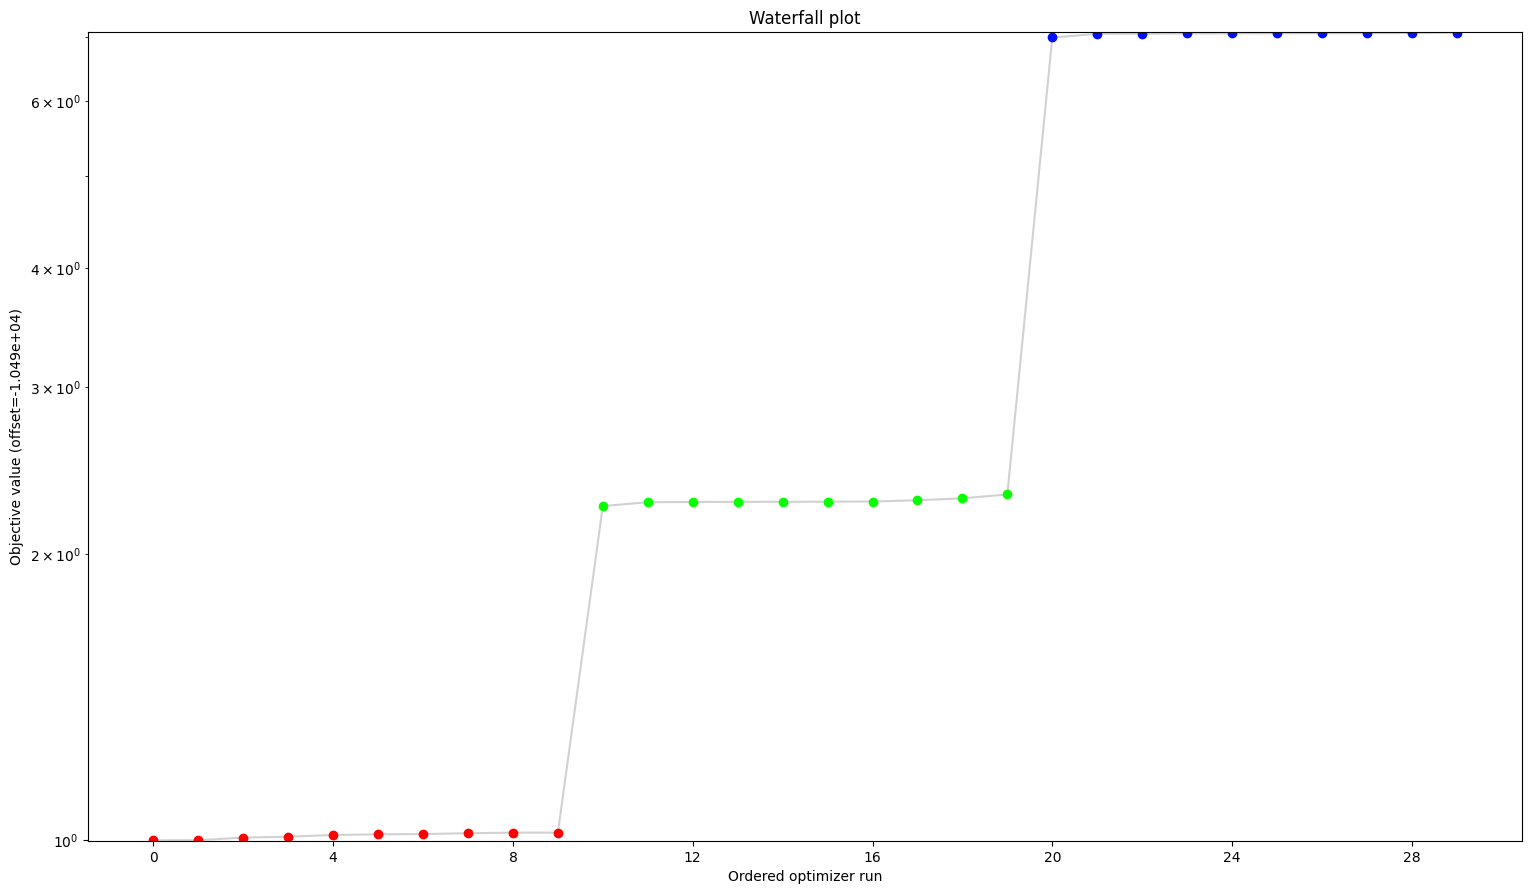

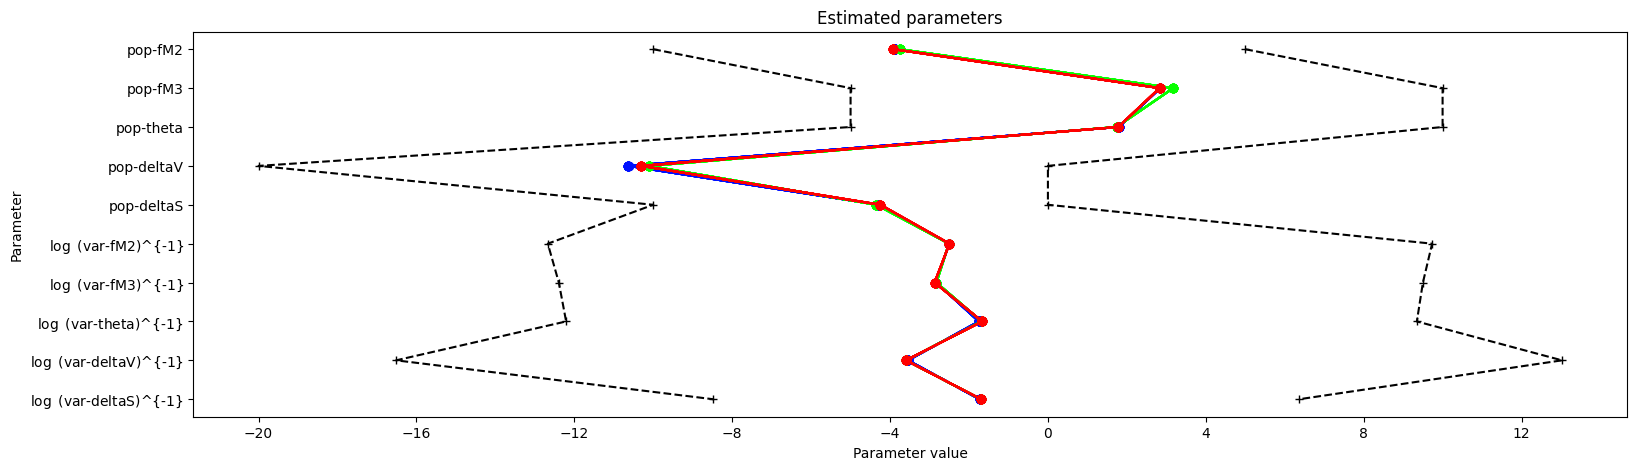

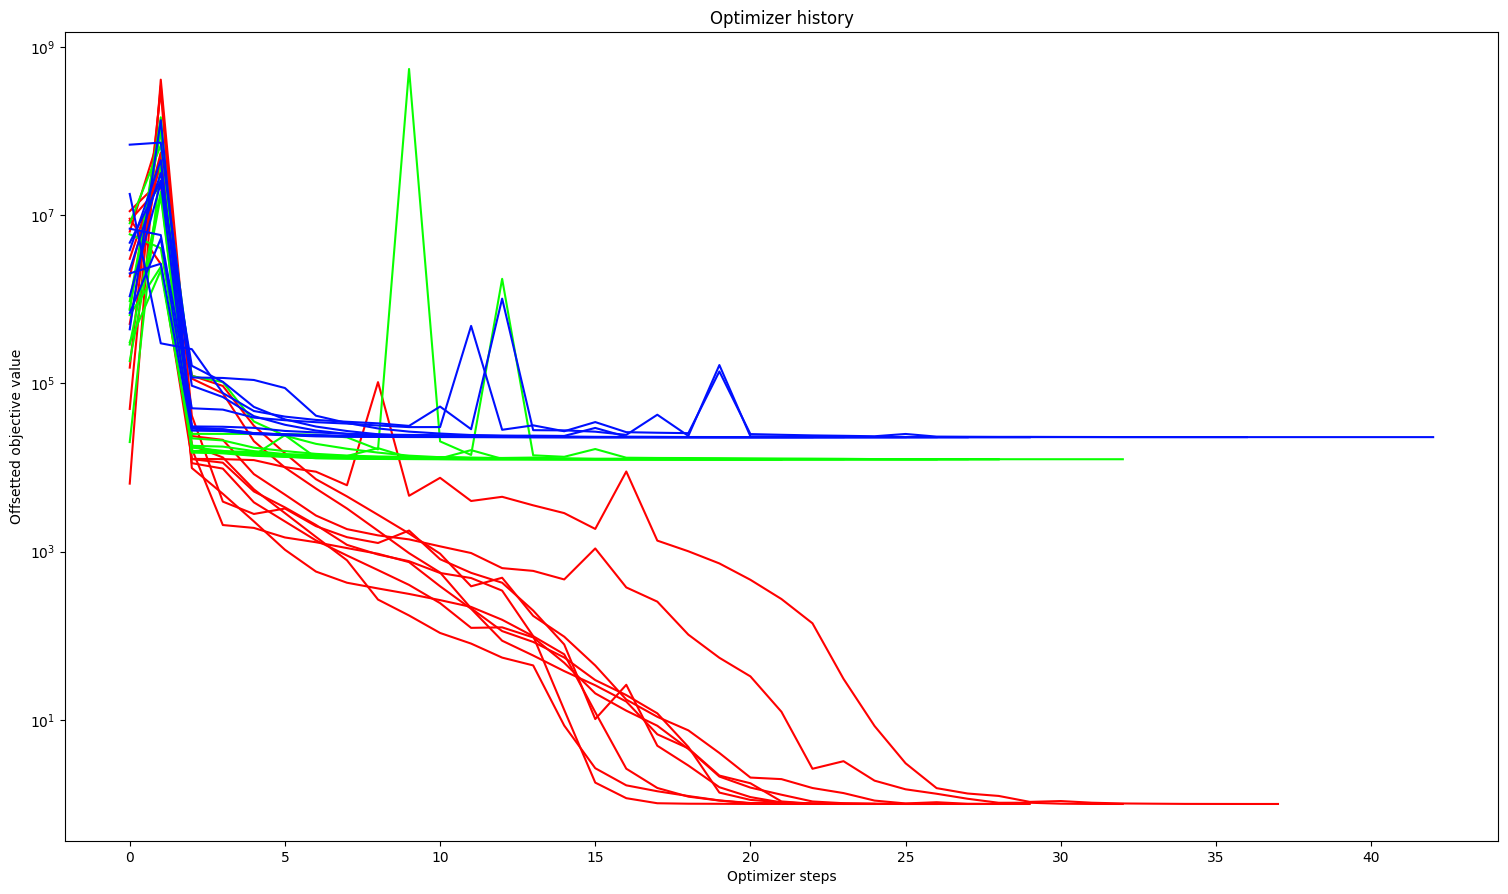

In [84]:
visualize_pesto_result(result_optimization)

In [85]:
if true_pop_parameters is not None:
    print('true values of log-normal distribution')
    df_param_sample = pd.DataFrame(true_pop_parameters[np.newaxis,:].round(4),
                               columns=full_param_names)
    display(df_param_sample)

if results_to_compare is not None:
    print('values of baseline method of log-normal distribution')
    df_param_sample = pd.DataFrame(results_to_compare, columns=full_param_names)
    display(df_param_sample)

print('estimated values of log-normal distribution')
results_transformed = transform_pesto_results(results, len(param_names), cov_type=cov_type)
df_param_sample = pd.DataFrame(results_transformed, columns=full_param_names)
display(df_param_sample)
#df_param_sample.to_csv(f'output/estimated_parameters_{model_name}_{n_data}.csv')

estimated values of log-normal distribution


,pop-fM2,pop-fM3,pop-theta,pop-deltaV,pop-deltaS,pop-error_1,pop-error_2,var-fM2,var-fM3,var-theta,var-deltaV,var-deltaS,var-error_1,var-error_2
0,-3.915217,2.829948,1.781401,-10.303025,-4.243151,-4.60517,-1.469676,12.110922,17.681262,5.281501,36.487229,5.427776,0.001595,0.001474
1,-3.914483,2.829555,1.781512,-10.304239,-4.243149,-4.60517,-1.469676,12.108195,17.681081,5.281043,36.484646,5.429848,0.001595,0.001474
2,-3.915409,2.829970,1.781603,-10.304328,-4.242844,-4.60517,-1.469676,12.110225,17.682878,5.281186,36.484229,5.427900,0.001595,0.001474
3,-3.915310,2.829447,1.781484,-10.304464,-4.242875,-4.60517,-1.469676,12.110054,17.681145,5.281827,36.484570,5.427670,0.001595,0.001474
4,-3.914653,2.829637,1.781480,-10.303603,-4.242766,-4.60517,-1.469676,12.110112,17.680737,5.281885,36.486617,5.428890,0.001595,0.001474
5,-3.914648,2.828425,1.781589,-10.304014,-4.242914,-4.60517,-1.469676,12.111015,17.681851,5.281608,36.485115,5.427901,0.001595,0.001474
6,-3.913276,2.828925,1.781306,-10.304493,-4.242806,-4.60517,-1.469676,12.111130,17.681098,5.281509,36.487642,5.427799,0.001595,0.001474
7,-3.913657,2.828675,1.781587,-10.304303,-4.242862,-4.60517,-1.469676,12.111019,17.681097,5.281803,36.485923,5.427817,0.001595,0.001474
8,-3.914853,2.829611,1.781666,-10.304570,-4.242825,-4.60517,-1.469676,12.111790,17.682020,5.282297,36.484414,5.427054,0.001595,0.001474
9,-3.915408,2.829560,1.781388,-10.304502,-4.242935,-4.60517,-1.469676,12.112606,17.684797,5.281931,36.478270,5.427875,0.001595,0.001474


In [86]:
df_param_sample.var(axis=0)

pop-fM2        5.062560e-03
pop-fM3        2.625172e-02
pop-theta      5.815930e-04
pop-deltaV     4.935300e-02
pop-deltaS     1.904462e-03
pop-error_1    0.000000e+00
pop-error_2    5.100394e-32
var-fM2        5.834671e-03
var-fM3        1.290492e-01
var-theta      4.217726e-02
var-deltaV     7.959010e-01
var-deltaS     1.094587e-02
var-error_1    1.945646e-37
var-error_2    4.377703e-37
dtype: float64

In [103]:
estimated_beta = results[0][:len(param_names)]
estimated_psi = obj_fun_amortized.get_covariance(results[0][len(param_names):])
estimated_psi_inv = obj_fun_amortized.get_inverse_covariance(results[0][len(param_names):])

In [104]:
display(estimated_beta)

array([ -3.91521695,   2.82994786,   1.78140074, -10.30302487,
        -4.24315062,  -4.60517019,  -1.46967597])

In [105]:
display(estimated_psi.diagonal())

array([1.21109223e+01, 1.76812622e+01, 5.28150145e+00, 3.64872290e+01,
       5.42777639e+00, 1.59538267e-03, 1.47426258e-03])

In [147]:
from scipy.special import logsumexp

In [208]:
n_samples_test = 1000
n_patients = 10
test_eval = np.zeros((n_patients, n_samples_test))

for i in range(n_patients):
    test_samples = model.draw_posterior_samples(data=obs_data, n_samples=n_samples_test)[i]
    test_function = lambda x: -0.5*(x-estimated_beta).dot(estimated_psi_inv).dot(x-estimated_beta)
    test_eval[i] = np.array([test_function(x) for x in test_samples])
    
    
test_expectation = np.exp(test_eval).sum(axis=1) / n_samples_test
test_variance = 1/(n_samples_test-1) * np.sum((np.exp(test_eval) - test_expectation[:, np.newaxis])**2, axis=1)
test_error = np.sqrt(test_variance/n_samples_test)
print(f'E={test_expectation}')
print(f'Var={test_variance}')
print(f'Error={test_error}')
   
print('\n')
print('log-sum-exp', np.log(test_expectation))
print('logsumexp', -np.log(n_samples_test)+logsumexp(test_eval, axis=1))
print('sumlogsumexp', np.sum(-np.log(n_samples_test)+logsumexp(test_eval, axis=1)))
print('error-order', (1/(n_samples_test-1)))

E=[1.13957867e-05 1.60704874e-09 1.45907411e-07 5.33271084e-06
 1.44029413e-09 4.56442615e-06 6.28721423e-13 1.70724483e-06
 2.01938451e-04 7.71348416e-15]
Var=[1.28153567e-07 2.58214693e-15 1.06372040e-11 2.65278400e-08
 2.07442000e-15 2.08321938e-08 3.39058479e-22 2.91339433e-09
 4.07791378e-05 4.04107369e-26]
Error=[1.13204932e-05 1.60690601e-09 1.03136822e-07 5.15051842e-06
 1.44028470e-09 4.56422982e-06 5.82287282e-13 1.70686682e-06
 2.01938451e-04 6.35694399e-15]


log-sum-exp [-11.38226686 -20.24886642 -15.74029358 -12.14165085 -20.35841849
 -12.29721776 -28.09508812 -13.2806297   -8.50754761 -32.49580641]
logsumexp [-11.38226686 -20.24886642 -15.74029358 -12.14165085 -20.35841849
 -12.29721776 -28.09508812 -13.2806297   -8.50754761 -32.49580641]
sumlogsumexp -174.54778579894253
error-order 0.001001001001001001


In [206]:
(1/(10-1))

0.1111111111111111

In [ ]:
np.random.seed(42)
from models.base_nlme_model import batch_gaussian_prior
synthetic_params = batch_gaussian_prior(mean=model.prior_mean-1, cov=model.prior_cov/2, batch_size=n_data) - 1
synthetic_params[:, -2:] = model.prior_mean[-2:]-1
true_pop_parameters = np.concatenate((np.mean(synthetic_params, axis=0), np.var(synthetic_params, axis=0)))
display(true_pop_parameters)

In [ ]:
display((estimated_beta-true_pop_parameters[:model.n_params])**2 / true_pop_parameters[:model.n_params]**2)

In [ ]:
display((estimated_psi.diagonal()-true_pop_parameters[model.n_params:])**2 / true_pop_parameters[model.n_params:]**2)

In [ ]:
simulator = model.build_simulator(with_noise=True)

In [ ]:
if 'fröhlich' in model_name:
    plot_real_vs_synthetic(estimated_mean=estimated_beta,
                           estimated_cov=estimated_psi,
                           data=obs_data,
                           model_name=model.name,
                           n_trajectories=len(obs_data),
                           simulator=simulator,
                           #save_fig='dif_ode', #model_name+'_eGFP_dif' if load_real_data else model_name+'_synthetic_dif',
                           #estimation_function=np.median,
                           ylim=(-1.,1.),
                           seed=0)
    plot_real_and_estimated(estimated_mean=estimated_beta,
                           estimated_cov=estimated_psi,
                           data=obs_data,
                           model_name=model.name,
                           n_trajectories=len(obs_data),
                           simulator=simulator,
                           #save_fig=model_name+'_eGFP_estimate' if load_real_data else model_name+'_synthetic_estimate',
                           seed=0)

In [ ]:
def plot_parameter_estimates(result_list: list[np.ndarray],
                             param_names_plot: list[str],
                             prior_mean: np.ndarray = None,
                             prior_std: np.ndarray = None,
                             true_parameters: np.ndarray = None,
                             run_names: list[str] = None,  # None, if multi-starts are compared
                             save_fig: bool = False) -> None:
    # plot parameters
    fig, ax = plt.subplots(figsize=(15, 5))  # , dpi=600)
    parameters_ind = list(range(1, result_list[0].shape[0] + 1))[::-1]

    if prior_mean is not None and prior_std is not None:
        n_pop_params = len(prior_mean)
        prior_interval = np.array([prior_mean - 1.96 * prior_std, prior_mean + 1.96 * prior_std]).T
        ax.fill_betweenx(parameters_ind[:n_pop_params], prior_interval[:, 0], prior_interval[:, 1],
                         color='grey', alpha=0.2, label='95% prior region')

    for j_x, x in reversed(list(enumerate(result_list))):
        if run_names is None:
            if j_x == 0:
                pass
                #tmp_legend = 'optimal run'
            else:
                tmp_legend = None
        else:
            tmp_legend = run_names[j_x]
        ax.plot(
            x,
            parameters_ind,
            linestyle='dashed',
            color='blue',
            marker='o',
            label=tmp_legend,
        )
        
    if true_parameters is not None:
        ax.plot(true_parameters, parameters_ind, color='red', marker='x',
                label='true parameters sample')
        
    ax.set_yticks(parameters_ind, param_names_plot)
    ax.set_xlabel('Parameter value')
    ax.set_ylabel('Parameter')
    ax.set_title('Estimated Population Parameters (log-normal distribution)')
    ax.legend(loc=2, bbox_to_anchor=(1, 1))
    fig.tight_layout()
    return

In [ ]:
plot_parameter_estimates(results_transformed,
                         param_names_plot=full_param_names,
                         prior_mean=prior_mean,
                         prior_std=prior_std,
                         true_parameters=true_pop_parameters,
                         save_fig=False)

In [ ]:
plot_estimated_distributions(results_transformed[0],
                             param_names_plot=param_names,
                             prior_mean=prior_mean,
                             prior_std=prior_std,
                             true_parameters=true_pop_parameters,
                             save_fig=False)

In [ ]:
if results_to_compare is not None:
    compare_list = [results_transformed[0], results_to_compare[0]]
    plot_parameter_estimates(compare_list, param_names_plot=full_param_names,
                         prior_mean=model.prior_mean,
                         prior_std=model.prior_std,
                         true_parameters=true_pop_parameters,
                         run_names=['BayesFlow', 'Baseline'],
                         save_fig=False)

    print('Baseline Estimated Parameters')
    plot_parameter_estimates(results_to_compare, param_names_plot=full_param_names,
                         prior_mean=model.prior_mean,
                         prior_std=model.prior_std,
                         save_fig=False)

# Uncertainty Analysis

Uncertainty based on profiles -> more accurate

In [ ]:
profile_options = profile.ProfileOptions(
    min_step_size=0.0005, #0.001
    step_size_factor=1.1, #1.25
    delta_ratio_max=0.05, #0.1
    default_step_size=0.005, #0.01
    ratio_min=0.01, #0.145
)

result_optimization = profile.parameter_profile(
    problem=result_optimization.problem,
    result=result_optimization,
    optimizer=optimize.ScipyOptimizer(),
    engine=engine.MultiProcessEngine(10),
    #profile_index=np.array([0]),
    #result_index=0, # index from which optimization result profiling should be started
    #profile_options=profile_options,
    #filename=f'output/uncertainty/{model.name}_cells_{n_data}_samples_{50}.hd5',
    #overwrite=True
)

In [ ]:
import matplotlib

matplotlib.rcdefaults()  # for resetting to defaults
plt.rcParams.update({'font.size': 14,
                     #'text.usetex': True,
                     "font.family": "serif",
                     "font.serif": ["Computer Modern Roman"],
                     'axes.titlesize': 'small',
                     'axes.labelsize': 'small',
                     'xtick.labelsize': 'xx-small', # todo: change back to small
                     'ytick.labelsize': 'small',
                     'legend.fontsize': 'small',
                     #'figure.dpi': 600,
                     'figure.figsize': (16,12)}) #
colors = ['#1f78b4', '#a6cee3', '#b2df8a','#33a02c','#fb9a99']

In [ ]:
ax = visualize.profiles(result_optimization, size=(16,12))
#plt.savefig('plots/synthetic_profiles_small_stochastic_data.pdf', bbox_inches='tight', dpi=600, format='pdf')
plt.show()

In [ ]:
ax = visualize.profile_cis(result_optimization) #,
                                  #profile_indices=[0,1,2,3,4,5,6,7,8,9,10,11])
ax.set_title('Approximate Confidence Intervals \n Based on Profiles')
plt.tight_layout()
#plt.savefig('plots/synthetic_FIM_profiles_cis.png')
plt.show()

Uncertainty based on FIM

In [ ]:
result_optimization = profile.approximate_parameter_profile(
    problem=result_optimization.problem,
    result=result_optimization,
    #profile_index=np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    #result_index=0, # index from which optimization result profiling should be started
)

In [ ]:
visualize.profiles(result_optimization)
#plt.savefig('plots/synthetic_FIM_profiles.png')
plt.show()

In [ ]:
n_indv = obs_data.shape[0]
confidence_ratio = profile.chi2_quantile_to_ratio(alpha=0.95, df=n_indv-(model.n_params*2))

confidence_intervals = np.zeros((model.n_params*2, 2))

for param_idx in range(model.n_params*2):
    try:
        xs = result_optimization.profile_result.list[0][param_idx]['x_path'][param_idx]
        ratios = result_optimization.profile_result.list[0][0]['ratio_path']
        confidence_intervals[param_idx] = profile.calculate_approximate_ci(xs, ratios,
                                                                            confidence_ratio=confidence_ratio)
    except TypeError:
        print(f'for {full_param_names[param_idx]} confidence interval could not be estimated')

confidence_intervals